# Introduction au réservoir optique de Larger

In [ ]:
%pip install reservoirpy==0.3.*

In [1]:
# IMPORTS

import numpy as np
from reservoirpy.datasets import mackey_glass

from model import Larger

In [2]:
# HYPER-PARAMÈTRES

n_neurones = 50  # Nombre de points temporels

tau = 125e-6  # Retard de la boucle
epsilon = tau / (0.2 * n_neurones)  # Temps de réponse du détecteur
beta = 1.5  # Gain non-linéaire
phi = 0.5  # Bias
# paramètre équivalent au coef de réflexion du coupleur d'une cavité en anneau
rho = 0.8
# paramètre équivalent au coef de transmission du coupleur d'une cavité en anneau
kappa = 0.5

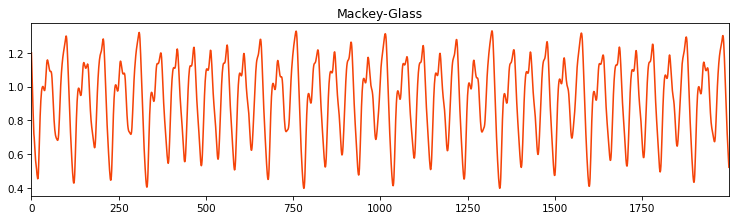

In [3]:
# DÉFINITION DE LA SÉRIE TEMPORELLE (signal)

n_tours = 2000  # Nombre de tours de boucle

timeseries = mackey_glass(n_timesteps=n_tours)

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 3))
plt.plot(timeseries)
plt.title("Mackey-Glass")
plt.show()

In [4]:
# CRÉATION DU RÉSERVOIR

reservoir = Larger(N=n_neurones, tau=tau, kappa=kappa, rho=rho, phi=phi, beta=beta, epsilon=epsilon)

TypeError: Can't instantiate abstract class Larger with abstract methods _step, initialize

In [ ]:
# LANCER LE RÉSERVOIR SUR LA SÉRIE

output = reservoir.run(timeseries)
print(f"{output.shape=}")

Running Larger-0: 100%|██████████| 2000/2000 [00:03<00:00, 510.10it/s]

output.shape=(2000, 50)


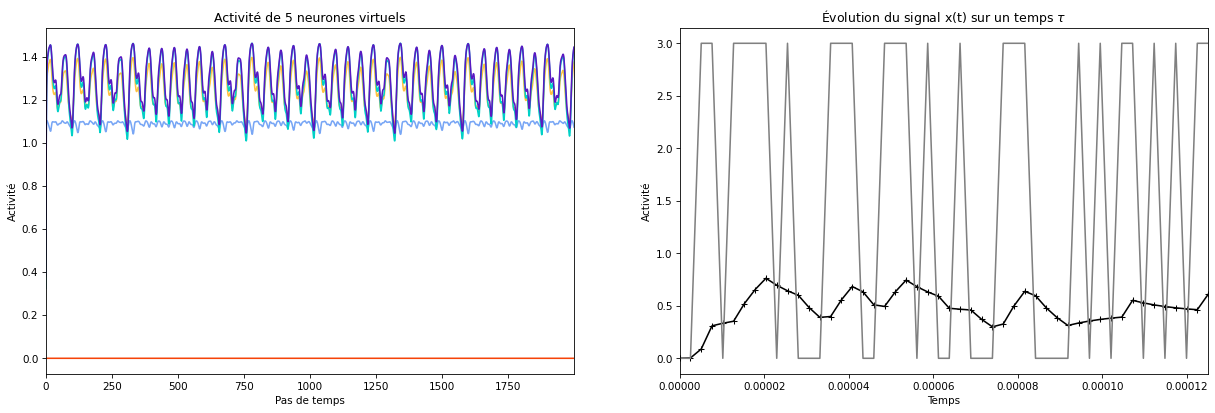

In [ ]:
# AFFICHAGE DE L'ACTIVITÉ
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

ax[0].plot(output[:, ::10])
ax[0].set_title("Activité de 5 neurones virtuels")
ax[0].set_xlabel("Pas de temps")
ax[0].set_ylabel("Activité")


ax[1].plot(np.linspace(0, tau, n_neurones), output[0, :], '-+', color="black", label="activity")
ax[1].plot(np.linspace(0, tau, n_neurones), reservoir.beta*(reservoir.input_mask[0]+1), color="gray", label="input mask")
ax[1].set_title("Évolution du signal x(t) sur un temps $\\tau$")
ax[1].set_xlabel("Temps")
ax[1].set_ylabel("Activité")

plt.show()

### Évaluation sur une tâche de prédiction

Maintenant qu'on a observé l'activité, il est temps d'entraîner un modèle complet !
La syntaxe est la même que pour un echo state network classique.

In [ ]:
# DÉFINITION DE LA TÂCHE DE PRÉDICTION

from reservoirpy.datasets import to_forecasting

X = mackey_glass(n_timesteps=n_tours)
# Ramener tout entre 0.0 et 1.0:
X = (X - X.min()) / (X.max() - X.min())

# Prédiction à 10 pas de temps, 20% des données servent à l'évaluation
dataset = to_forecasting(X, forecast=10, test_size=0.2)
x_train, x_test, y_train, y_test = dataset

In [ ]:
# CRÉATION DU MODÈLE

# Il suffit de connecter le réservoir au read-out (couche de sortie)
from reservoirpy.nodes import Ridge

reservoir = Larger(N=n_neurones, tau=tau, kappa=kappa, rho=rho, phi=phi, beta=beta, epsilon=epsilon)
readout = Ridge(ridge=1e-8)

model = reservoir >> readout

In [ ]:
# ENTRAÎNEMENT DU MODÈLE

model.fit(x_train, y_train, warmup=100)

Running Model-0: 1590it [00:03, 491.51it/s]0<?, ?it/s]
Running Model-0: 100%|██████████| 1/1 [00:03<00:00,  3.24s/it]


Fitting node Ridge-0...


'Model-0': Model('Larger-1', 'Ridge-0')

Running Model-0: 400it [00:00, 495.01it/s]            


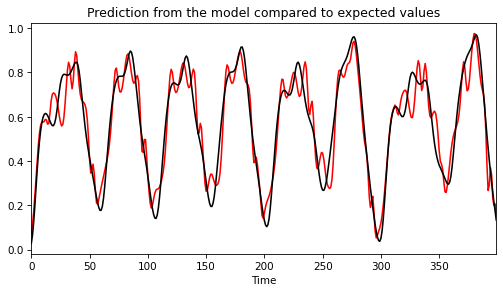

NRMSE = 0.07997744783908782


In [ ]:
# ÉVALUATION DES RÉSULTATS

from reservoirpy.observables import nrmse

y_pred = model.run(x_test)

plt.figure(figsize=(8, 4))
plt.plot(y_pred, label="Prediction", color="red")
plt.plot(y_test, label="True", color="black")
plt.title("Prediction from the model compared to expected values")
plt.xlabel("Time")
plt.show()

print(f"NRMSE = {nrmse(y_pred=y_pred, y_true=y_test)}")

## Exploration des hyper-paramètres

En se basant sur les deux premières visualisations, et sur les métriques d'erreur de prédiction, explorons l'impact des différents hyper-paramètres (`n_neurones`, $\epsilon, \beta, \kappa, \rho, \tau, \phi_0$) sur le réservoir optique.

En modifiant les hyper-paramètres listés plus haut, visualisez à la fois l'activité des neurones virtuels au cours du temps, et l'état des différents neurones au cours d'un temps $t \rightarrow t+\tau$

**Rappel de la formule:**
$$\epsilon {dx(t) \over dt} + x(t) = \beta sin^2(\kappa u_{in}(t) + \rho x(t - \tau) + \phi_0)$$

### Faisons varier les paramètres un-à-un

On n'explorera pas ici `n_neurones` (on s'attend à ce que plus de neurones apporte plus de richesse d'activité).

$\tau$ n'est pas non plus un paramètre à explorer: il y a une corrélation directe entre $\tau$ et $\epsilon$: concrètement, modifier $\tau$ revient à modifier la taille de la segmentation de l'activité du système $x(t)$, donc à faire tourner le réservoir plus rapidement. On peut alors obtenir la même dynamique en ajustant le temps de réponse du détecteur.

In [ ]:
# réduire la verbosité
import reservoirpy as rpy
rpy.verbosity(0)

0

In [ ]:
n_neurones = 50  # Nombre de points temporels
tau = 125e-6  # Retard de la boucle
epsilon = tau / (0.2 * n_neurones)  # Temps de réponse du détecteur
beta = 1.5  # Gain non-linéaire
phi = 0.5  # Bias
rho = 0.8  # coef. de réflexion du coupleur d'une cavité en anneau
kappa = 0.5  # coef. de transmission du coupleur d'une cavité en anneau
ridge = 1e-6 # régularisation de la couche de sortie

# on réduit le nombre de pas de temps: temps d'entraînement/prédiction plus court
X = mackey_glass(n_timesteps=500)
X = (X - X.min()) / (X.max() - X.min())
dataset = to_forecasting(X, forecast=10, test_size=0.2)
x_train, x_test, y_train, y_test = dataset

In [ ]:
def run_on_params(n_neurones, tau, epsilon, beta, phi, rho, kappa, ridge):
    reservoir = Larger(N=n_neurones, tau=tau, kappa=kappa, rho=rho, phi=phi, beta=beta, epsilon=epsilon)
    readout = Ridge(ridge=ridge)
    model = reservoir >> readout

    model.fit(x_train, y_train, warmup=10)
    y_pred = model.run(x_test)
    return y_pred

#### Paramètre epsilon $\epsilon$

NRMSE(2.5e-05) = 0.1743
NRMSE(5e-06) = 0.1306
NRMSE(2.5e-06) = 0.1164
NRMSE(1.25e-06) = 0.1115


/home/paul/anaconda3/envs/py313/lib/python3.13/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.94345e-68): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


NRMSE(5e-07) = 0.8022


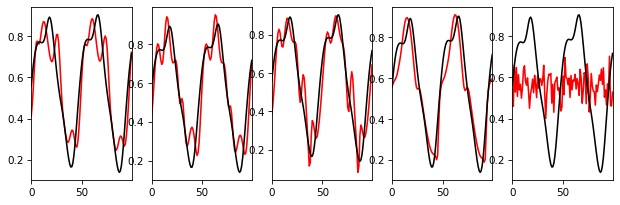

In [ ]:
epsilons = tau / (np.array([0.1, 0.5, 1.0, 2.0, 5.0]) * n_neurones)

plt.figure(figsize=(10, 3))

for i, epsilon in enumerate(epsilons):
    y_pred = run_on_params(n_neurones, tau, epsilon, beta, phi, rho, kappa, ridge)
    
    plt.subplot(1, len(epsilons), i+1)
    plt.plot(y_pred, color="red")
    plt.plot(y_test, color="black")
    print(f"NRMSE({epsilon}) = {nrmse(y_pred, y_test):.4}")

plt.show()

epsilon = tau / (0.2 * n_neurones)  # Reset de la variable epsilon

#### Paramètre phi $\phi_0$

Ce paramètre indique "où on se situe" sur le $sin^2$. Du fait de la $\pi$-périodicité, on l'explore entre $0$ et $\pi$

NRMSE(0.0) = 0.3191
NRMSE(0.6283185307179586) = 0.1892
NRMSE(1.2566370614359172) = 0.1902
NRMSE(1.8849555921538759) = 0.22
NRMSE(2.5132741228718345) = 0.212


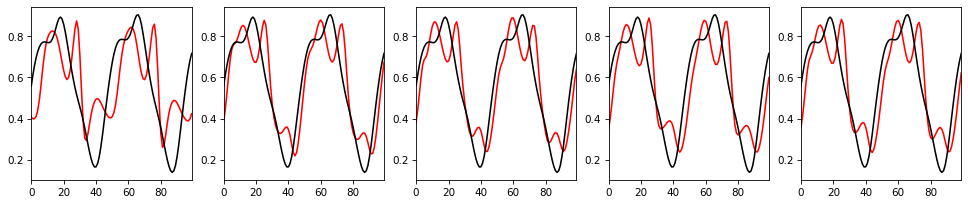

In [ ]:
phis = np.pi * np.array([0.0, 0.2, 0.4, 0.6, 0.8])

plt.figure(figsize=(16, 3))

for i, phi in enumerate(phis):
    y_pred = run_on_params(n_neurones, tau, epsilon, beta, phi, rho, kappa, ridge)
    
    plt.subplot(1, len(phis), i+1)
    plt.plot(y_pred, color="red")
    plt.plot(y_test, color="black")
    print(f"NRMSE({phi}) = {nrmse(y_pred, y_test):.4}")

plt.show()

phi = 0.5  # reset de phi

## Analyse mathématique de l'impact des hyper-paramètres

- Pourquoi certains hyper-paramètres ont un impact important et pas d'autres ?
- Est-ce qu'il y a une interdépendance entre différents hyper-paramètres ?
- Quels hyper-paramètres choisir ?
- Pourquoi une exploration d'hyper-paramètres classique ([voir le tutoriel ReservoirPy](https://github.com/reservoirpy/reservoirpy/blob/master/tutorials/4-Understand_and_optimize_hyperparameters.ipynb)) ne fonctionne pas ici ?

$$\epsilon {dx(t) \over dt} + x(t) = \beta sin^2(\kappa u_{in}(t) + \rho x(t - \tau) + \phi_0)$$

Le comportement non-linéaire du réservoir Larger est porté par l'existence du $sin^2$ (physiquement, c'est le modulateur Mach-Zehnder).
S'il n'existait pas, on se retrouverait avec un système linéaire, duquel on ne récupère généralement pas des dynamiques assez riches pour des tâches de machine learning.

En revanche, la périodicité de la fonction $sin^2$ peut rendre le comportement du signal $x$ imprévisible (chaotique). Pour le démonstrer, on évalue l'évolution d'un système itératif qui est une simplification de notre modèle:

$u_{n+1} = sin^2(\rho u_n + \phi)$

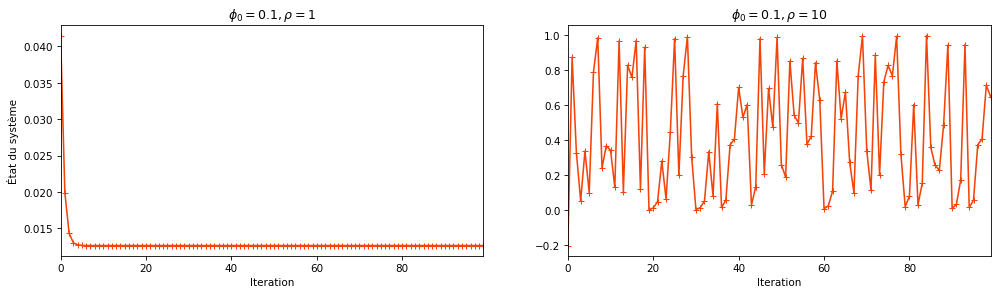

In [ ]:
n_iter = 100

# Pour phi=0.1, rho=2
phi, rho = 0.1, 1
x1 = np.empty(n_iter)
for i in range(1, n_iter):
    x1[i] = np.square(np.sin(rho*x1[i-1]+phi))

# Pour phi=0.1, rho=10
phi, rho = 0.1, 10
x2 = np.empty(n_iter)
for i in range(1, n_iter):
    x2[i] = np.square(np.sin(rho*x2[i-1]+phi))

plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot(x1, '-+')
plt.xlabel("Iteration")
plt.ylabel("État du système")
plt.title(f"$\\phi_0 = 0.1, \\rho = 1$")

plt.subplot(1, 2, 2)
plt.plot(x2, '-+')
plt.xlabel("Iteration")
plt.title(f"$\\phi_0 = 0.1, \\rho = 10$")
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'spines'

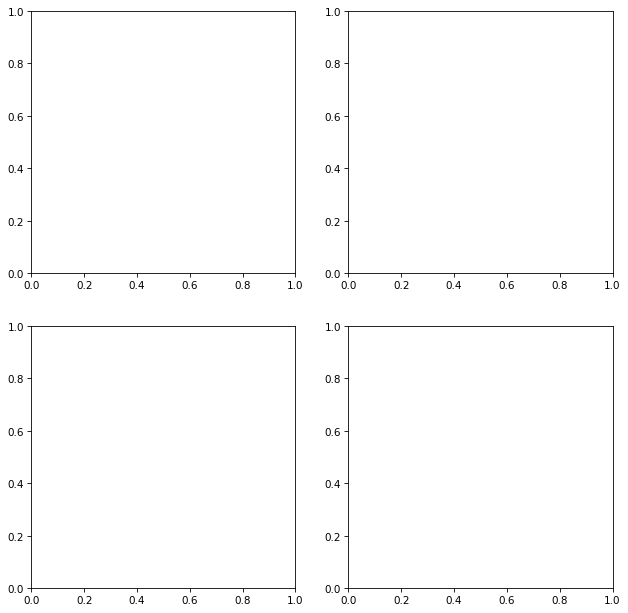

In [ ]:
x_vals = np.linspace(-0.5, 1.5, 1000)

identity = x_vals
system1 = np.square(np.sin(1*x_vals+0.1))
system2 = np.square(np.sin(10*x_vals+0.1))

# plot
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')

ax.plot(x_vals, identity, color="green", label="identity")
ax.plot(x_vals, system2, color="red", label="f")
ax.grid()

plotted_iters = 10
assert plotted_iters <= n_iter
for i in range(1, plotted_iters):
    ax.plot([x2[i], x2[i]], [x2[i], x2[i-1]], '--', color="black")
    ax.plot([x2[i-1], x2[i]], [x2[i-1], x2[i-1]], '--', color="black")

ax.plot([0], [0], '--', color="black", label="iterative system")

plt.title("Iterative system for $\\beta=10$")
plt.legend()

plt.show()

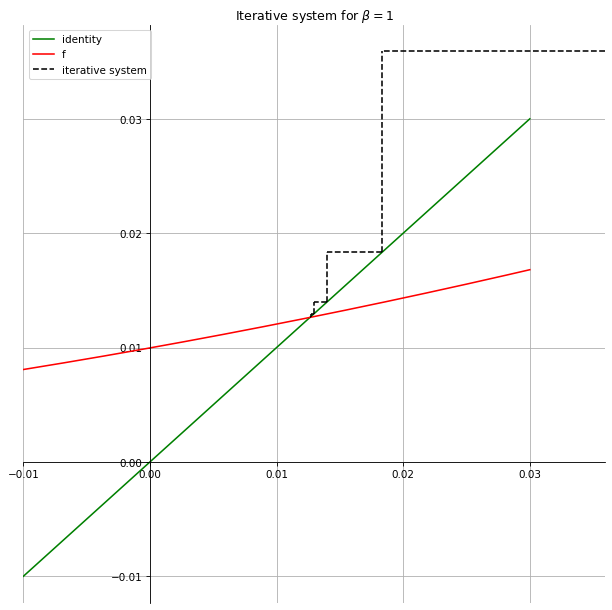

In [ ]:
x_vals = np.linspace(-0.01, 0.03, 1000)

identity = x_vals
system1 = np.square(np.sin(1*x_vals+0.1))

# plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')

ax.plot(x_vals, identity, color="green", label="identity")
ax.plot(x_vals, system1, color="red", label="f")
ax.grid()

plotted_iters = 10
assert plotted_iters <= n_iter
for i in range(1, plotted_iters):
    ax.plot([x1[i], x1[i]], [x1[i], x1[i-1]], '--', color="black")
    ax.plot([x1[i-1], x1[i]], [x1[i-1], x1[i-1]], '--', color="black")

ax.plot([0], [0], '--', color="black", label="iterative system")

plt.title("Iterative system for $\\beta=1$")
plt.legend()

plt.show()